**Загрузка библиотек**

In [213]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
random.seed(42)
plt.rcParams["font.family"] = "serif"

**Загрузка данных**

In [215]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Internship/VK_2021/ProductAnalytics/part_C/task_for_a_prod_analytics_trainee_part_c.csv')

In [216]:
df.head()

,hashed_user_id,user_age,user_sex,user_friends,user_communities_count,user_fans_count,user_subscriptions_count,device_brand,device_model,days_in_vk_1_week,days_in_vk_2_weeks,days_in_vk_4_weeks,days_in_vk_8_weeks,messaging_total,calls_accepted,timespent_total,timespent_im,timespent_feed,timespent_photo,timespent_video,timespent_clips,timespent_audio,timespent_story
0,$1VAQ97BmCCZc,26,male,481,476,361,177,lge,LG-M250,7,14,28,56,1,0,501,0,55,0,0,0,0,0
1,$1v/FKogrWnz2,26,female,115,72,419,0,Apple,iPhone 7,7,14,28,56,23,0,0,0,0,0,0,0,0,0
2,$1eoMEtyVB3XM,26,female,297,317,2681,0,Apple,iPhone 11 Pro Max,7,14,28,56,33,0,0,0,0,0,0,0,0,0
3,$12ZhvNRMpcZU,20,male,147,130,216,0,samsung,SM-G970F,7,14,28,56,1,0,5085,101,2371,0,0,0,0,0
4,$1mD0tDgB13tk,39,male,138,311,51,33,NaN,NaN,7,14,28,56,3,0,1301,0,0,0,0,0,0,0


In [217]:
df.shape

(125893, 23)

**Анализ датасета**

In [218]:
print('Кол-во дупликатов в hashed_user_id: ', df[df.duplicated(subset='hashed_user_id')].shape[0])
print('Кол-во дупликатов в датасете: ', df[df.duplicated()].shape[0])

Кол-во дупликатов в hashed_user_id:  234
Кол-во дупликатов в датасете:  0


В датасете присутствуют дупликаты хэшей, например:

In [219]:
df[df['hashed_user_id'] == '$1/Id5yX77O3w']

,hashed_user_id,user_age,user_sex,user_friends,user_communities_count,user_fans_count,user_subscriptions_count,device_brand,device_model,days_in_vk_1_week,days_in_vk_2_weeks,days_in_vk_4_weeks,days_in_vk_8_weeks,messaging_total,calls_accepted,timespent_total,timespent_im,timespent_feed,timespent_photo,timespent_video,timespent_clips,timespent_audio,timespent_story
91138,$1/Id5yX77O3w,0,female,334,169,85,82,NaN,NaN,7,12,24,52,0,0,0,0,0,0,0,0,0,0
123412,$1/Id5yX77O3w,24,male,30,45,112,63,HONOR,HRY-LX1T,7,14,28,56,11,0,3699,103,2091,425,35,0,17,151


Однако, судя по всему, это разные пользователи, так как дупликатов целых строк нет.

Процент пропущенныех значений:

In [220]:
df.isnull().sum() / df.shape[0] * 100

hashed_user_id               0.000000
user_age                     0.000000
user_sex                     0.000000
user_friends                 0.000000
user_communities_count       0.000000
user_fans_count              0.000000
user_subscriptions_count     0.000000
device_brand                14.968267
device_model                15.207359
days_in_vk_1_week            0.000000
days_in_vk_2_weeks           0.000000
days_in_vk_4_weeks           0.000000
days_in_vk_8_weeks           0.000000
messaging_total              0.000000
calls_accepted               0.000000
timespent_total              0.000000
timespent_im                 0.000000
timespent_feed               0.000000
timespent_photo              0.000000
timespent_video              0.000000
timespent_clips              0.000000
timespent_audio              0.000000
timespent_story              0.000000
dtype: float64

Распределение категориальных переменных:

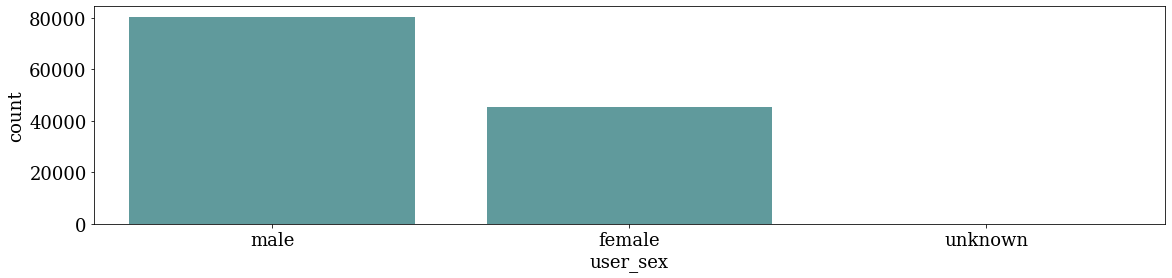

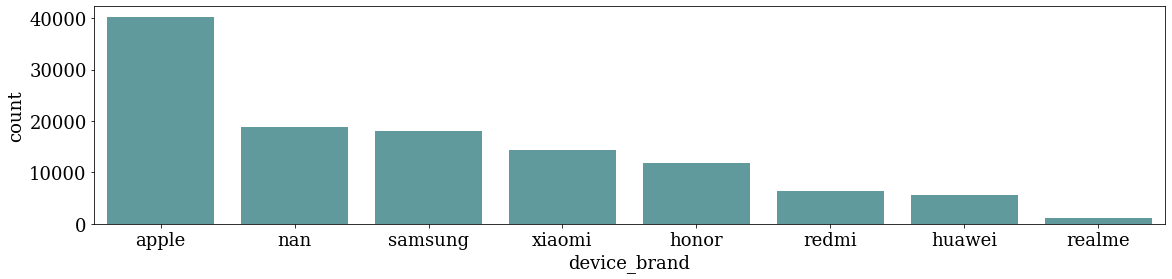

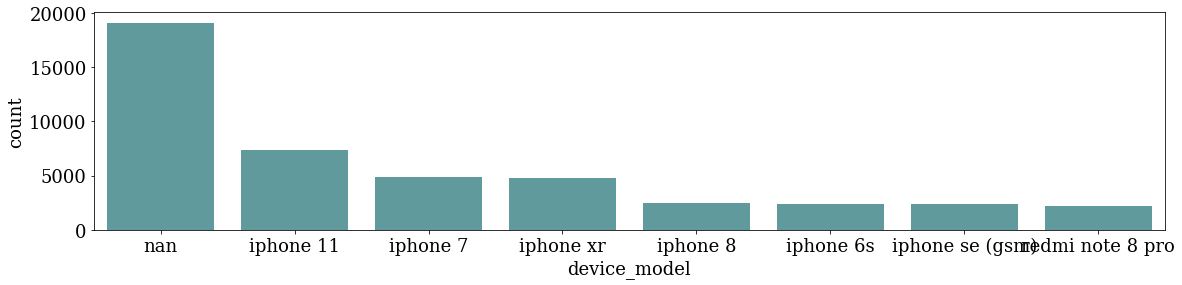

In [221]:
cat_features = ['user_sex', 'device_brand', 'device_model']
df[cat_features] = df[cat_features].astype('str')
for col in cat_features:
    df[col] = df[col].str.lower()
for col in cat_features:
    fig, ax = plt.subplots(figsize=(19.20,4))
    sns.countplot(data=df, x=col, palette = ['#56a3a6'], 
                  order=df[col].value_counts().iloc[:8].index)
    ax.tick_params(labelsize = 18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    plt.show()

График device_model со всеми видами айфона, объединенных в один вид.

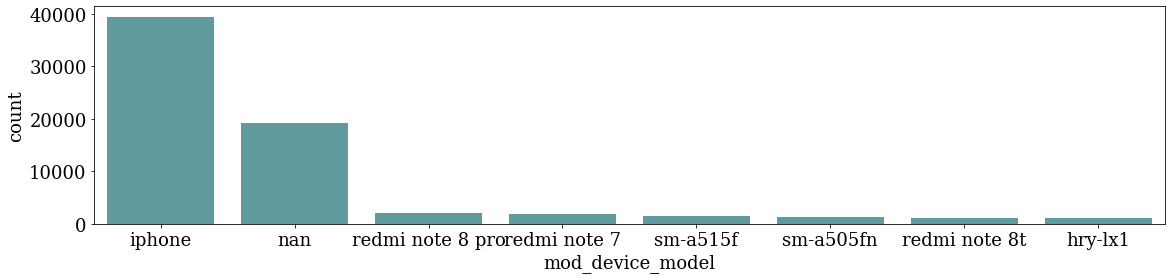

In [222]:
df['mod_device_model'] = df['device_model']
df.loc[df['mod_device_model'].str.startswith('iphone'), 'mod_device_model'] = 'iphone'
fig, ax = plt.subplots(figsize=(19.20,4))
sns.countplot(data=df, x='mod_device_model', palette = ['#56a3a6'], 
              order=df['mod_device_model'].value_counts().iloc[:8].index)
ax.tick_params(labelsize = 18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.show()

В нашей выборке больше мужчин, чем женщин. Большинство пользователей просматривает ВКонтакте, используя технику apple. Чуть больше 15 % выборки не использую никакие мобильные устройста для просмотра ВКонтакте (столбец nan). Также распространены андроид-смартфоны компаний samsung, xiaomi, honor, redmi и др.

Распределение непрерывных переменных:

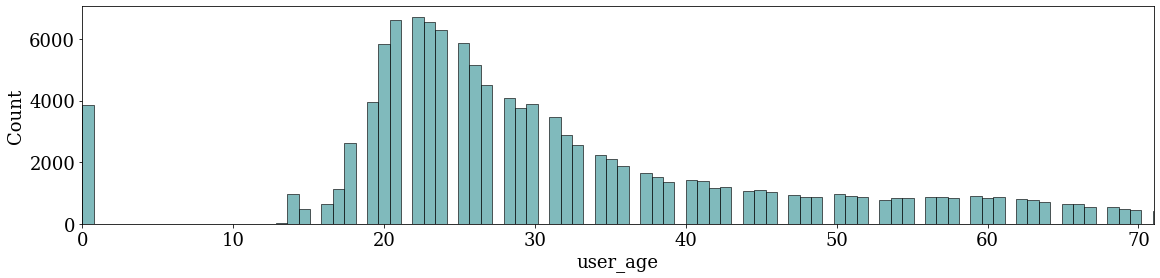

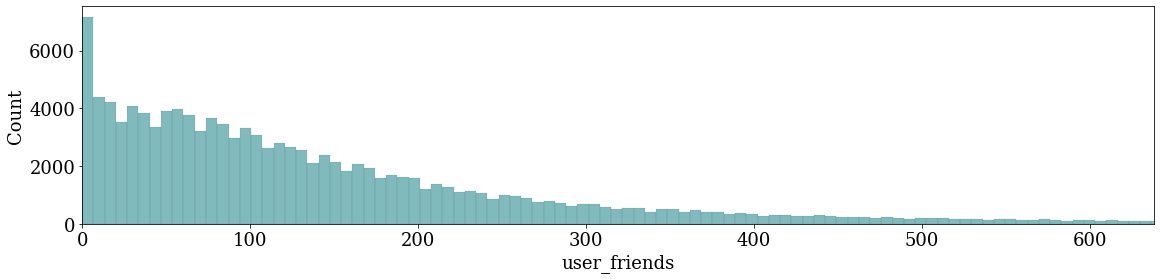

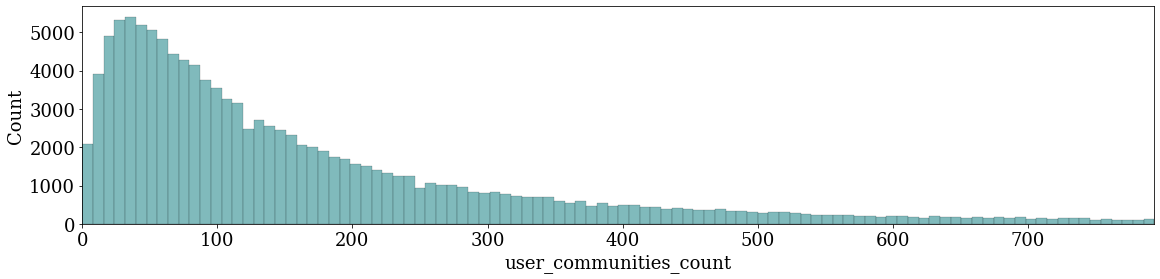

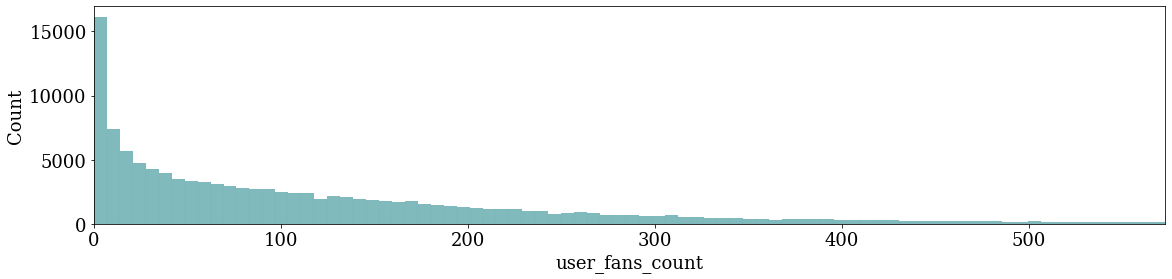

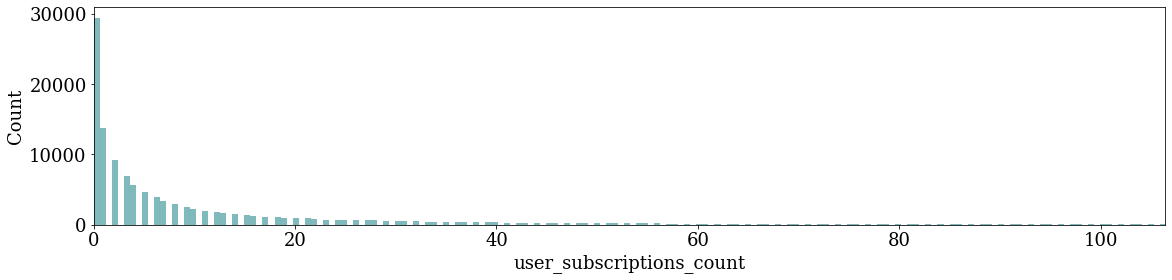

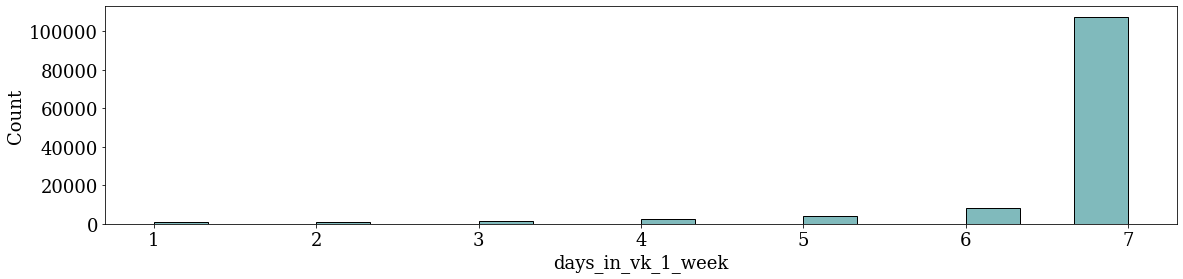

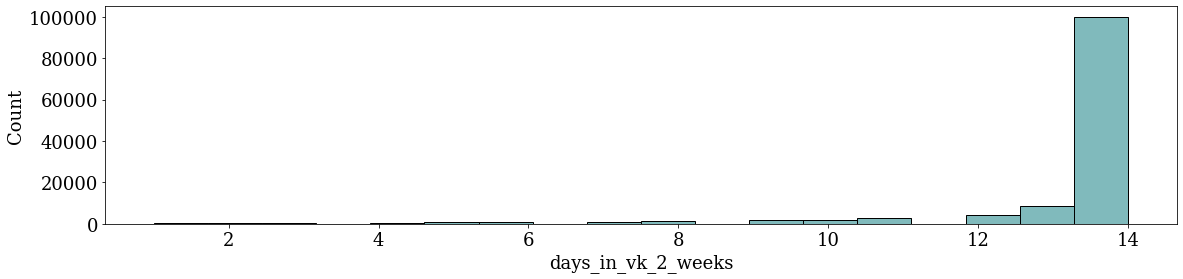

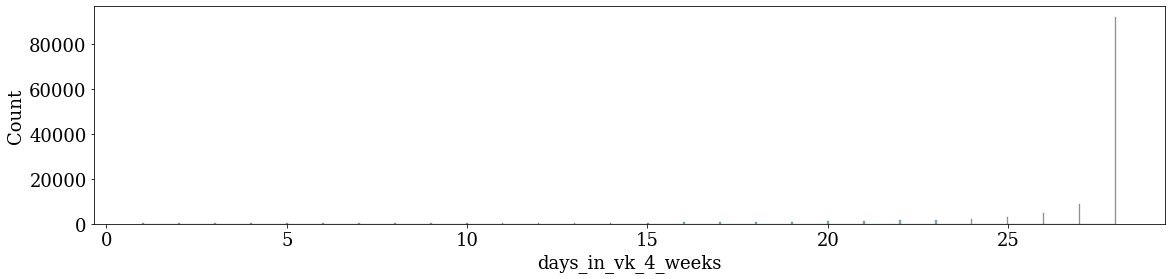

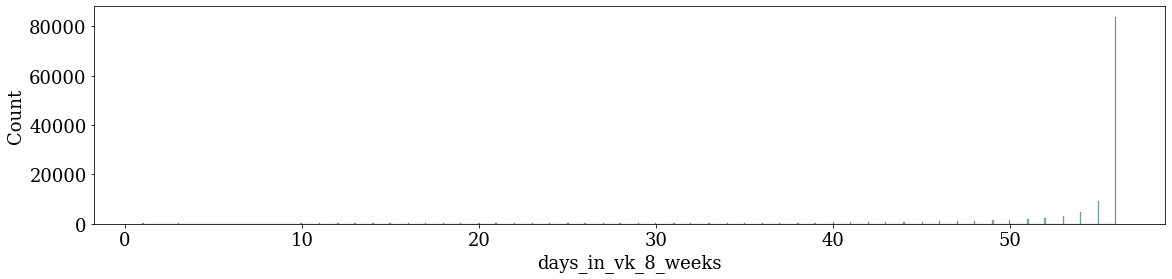

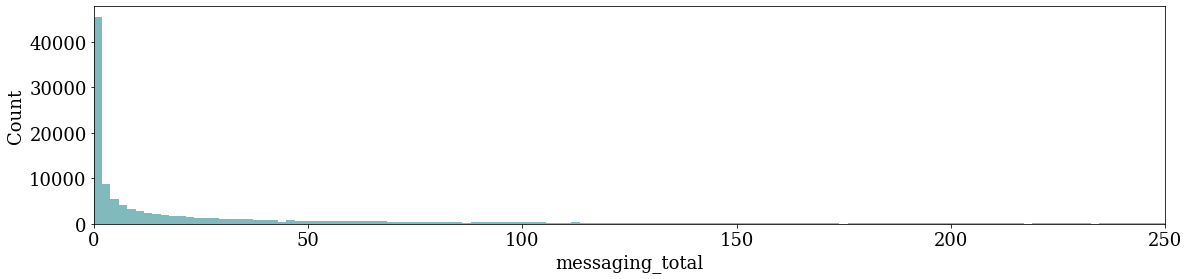

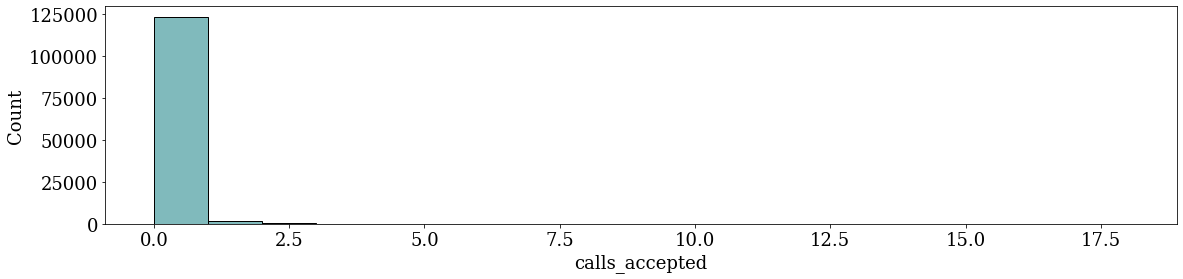

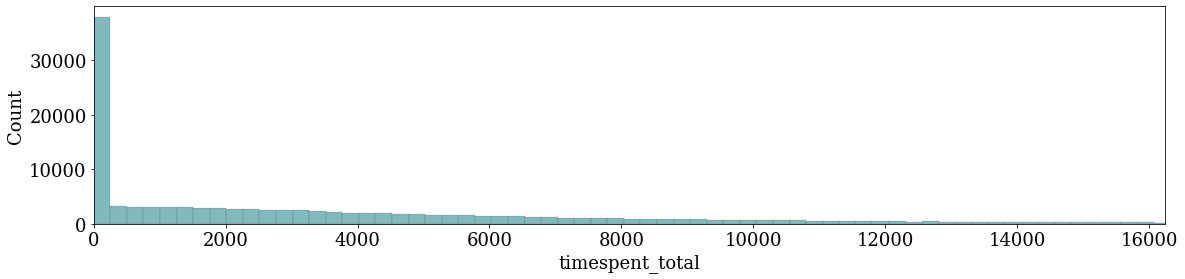

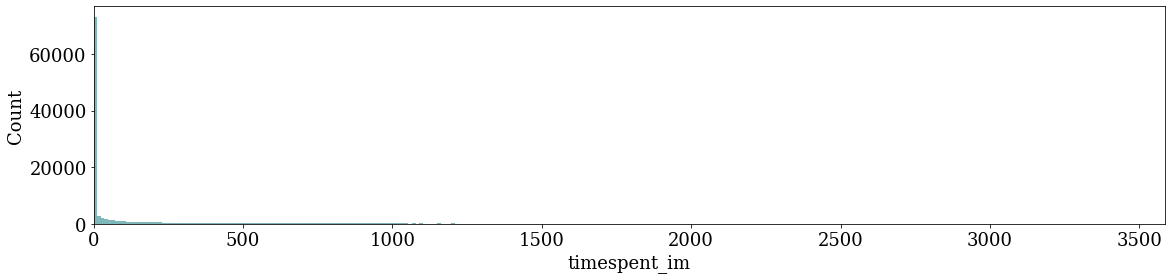

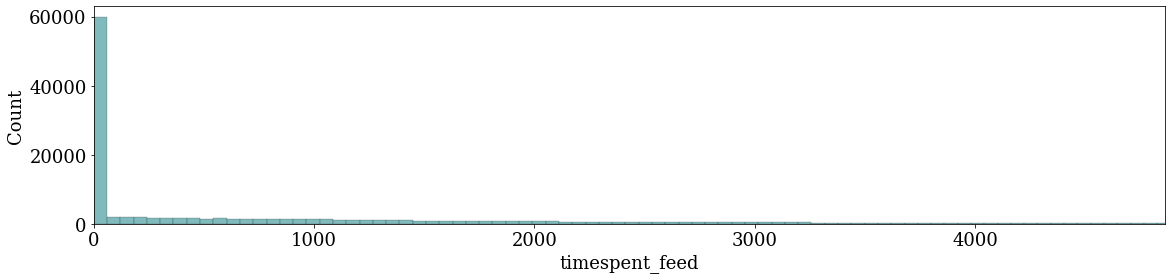

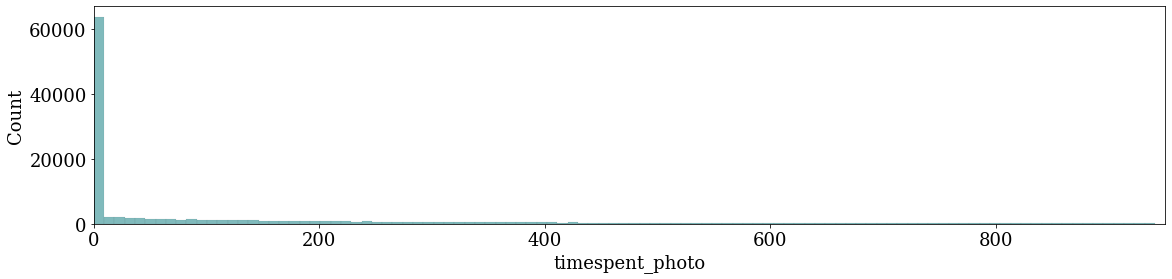

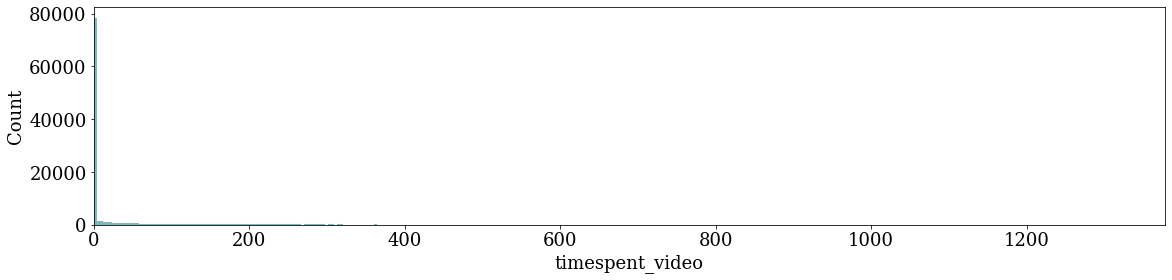

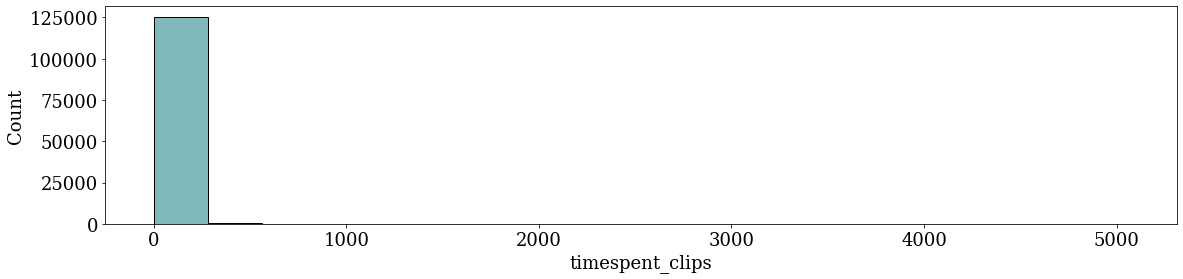

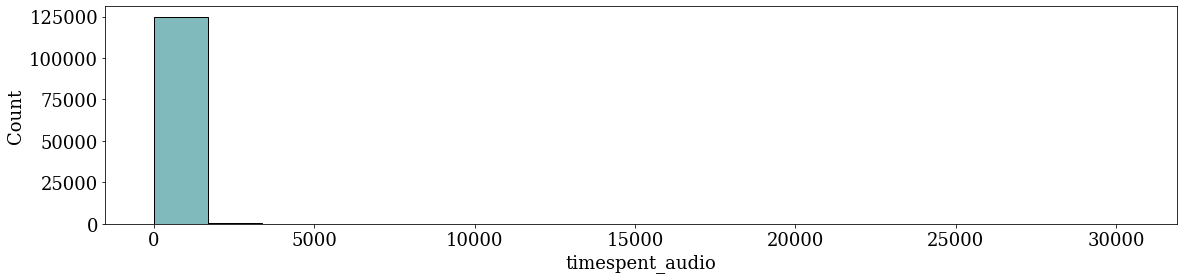

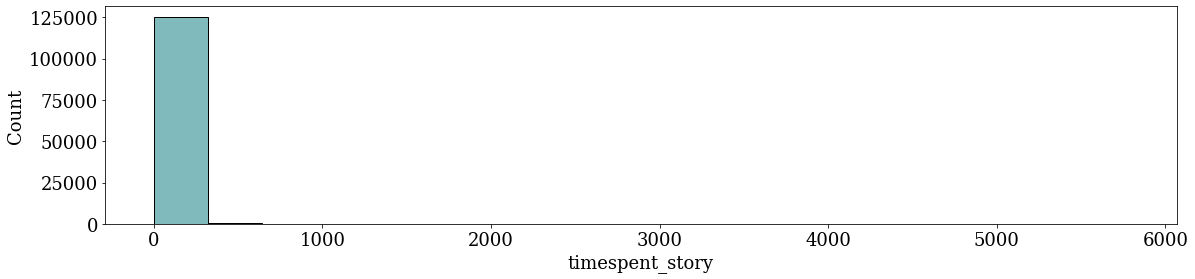

In [223]:
num_features = ['user_age', 'user_friends', 'user_communities_count', 'user_fans_count', 'user_subscriptions_count', 'days_in_vk_1_week', 
                'days_in_vk_2_weeks', 'days_in_vk_4_weeks', 'days_in_vk_8_weeks', 'messaging_total', 'calls_accepted', 'timespent_total', 
                'timespent_im', 'timespent_feed', 'timespent_photo', 'timespent_video', 'timespent_clips', 'timespent_audio', 'timespent_story']
for col in num_features:
    fig, ax = plt.subplots(figsize=(19.20,4))
    sns.histplot(data=df, x=col, color='#56a3a6') 
    ax.tick_params(labelsize = 18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    if col not in {'days_in_vk_1_week', 'days_in_vk_2_weeks', 'days_in_vk_4_weeks', 'days_in_vk_8_weeks', 'calls_accepted',
                   'timespent_clips', 'timespent_audio', 'timespent_story'}: # у этих колонок выбросы не критичны
        plt.xlim(0, np.quantile(df[col], 0.95)) # устанавливаем лимит, чтобы выбросы не портили график
    plt.show()

Интересные детали из этих графиков: 


*   Пользователи в большинстве своем младше 30;
*   Большая часть пользователей заходит в соцсеть каждый день;
*   Крайне малая часть выборки пользуется звонками;
*   Большая часть пользователей проводит мало времени в аудиозаписях, видеозаписях, историях, клипах;
*   В большинство колонок у нас присутствуют значительные выбросы.



**Выделение групп пользователей**

Для выявления групп пользователей я буду пользоваться алгоритмами кластеризации. Однако большинство из них не работает с категориальными признаками. Нужно преобразовать данные.

Для начала я хочу изменить значения столбца возрастов. У почти 4 тысяч пользователей значение возраста равно 0. Я полагаю, что это метка не указанного возраста. Кроме этого, у еще 4 тысяч пользователей значение возраста больше 90. Это явно некорректные значения, которые пользователи наверняка поставили в качестве шутки. Заменим эти значения случайной вставкой из других значений (аппроксимируя распределение).

In [224]:
df['mod_user_age'] = df['user_age']
# создаем выборку с повторениями из остальных возрастов
sample = random.choices(list(df.loc[~((df['user_age'] >= 90) | (df['user_age'] == 0)), 'mod_user_age']), 
                        k=df.loc[((df['user_age'] >= 90) | (df['user_age'] == 0)), ].shape[0])
# вставляем эту выборку вместо "некорректных" возрастов
df.loc[((df['user_age'] >= 90) | (df['user_age'] == 0)), 'mod_user_age'] = sample

Категориальные переменные я закодирую следующим образом:

*   user_sex - дамми для каждого из вариантов;
*   device_brand - все варианты, кроме apple и nan, перекодируем в android и сделаем dummy-переменные;
*   device_model - разных моделей слишком много, поэтому возьмем только номера айфонов (ими пользуется треть выборки). 0 - отсуствие айфона.



In [225]:
# user_sex и device_brand
df['mod_device_brand'] = df['device_brand']
df.loc[(df['device_brand'] != 'apple') & (df['device_brand'] != 'nan') , 
       'mod_device_brand'] = 'android' # создаем категорию для редких телефонов на андроид
df = pd.get_dummies(df, columns=['user_sex', 'mod_device_brand']) # dummy для 'user_sex' и популярных моделей 'mod_device_brand'
# device_model
df['iphone_model'] = df['device_model'] 
iphones = {'iphone 11':11, # словарь с численной оценкой моделей Iphone
 'iphone 7':7,
 'iphone xr':10,
 'iphone 8':8,
 'iphone 6s': 6.5,
 'iphone se (gsm)': 6,
 'iphone x gsm':10.1,
 'iphone 8 plus':8.5,
 'iphone 7 plus':7.5,
 'iphone 6':6,
 'iphone se 2':10.9,
 'iphone xs':10.5,
 'iphone 11 pro':11.5,
 'iphone 12': 12,
 'iphone 11 pro max':11.8,
 'iphone 5s (global)':5.8,
 'iphone xs max global':10.5,
 'iphone 12 pro max':12.8,
 'iphone 12 pro':12.5,
 'iphone 12 mini':12,
 'iphone 6s plus':6.8,
 'iphone x global':10,
 'iphone 6 plus':6.5,
 'iphone 5s (gsm)':5.8,
 'iphone 5 (gsm+cdma)': 5,
 'iphone 5 (gsm)': 5,
 'iphone 5c (global)':5.5,
 'iphone 5c (gsm)':5.5}

df = df.replace({'iphone_model': iphones}) # заменяет модели айфонов на числа
df['iphone_model'] = ( 
    pd.to_numeric(df['iphone_model'],
                  errors='coerce')
      .fillna(0)
    ) # модели - не айфоны заменяем на 0
df.loc[df['device_brand'] != 'apple', 'iphone_model'] = 0 # модели - не айфоны заменяем на 0

Для кластеризации я использую алгоритм K-Means, так как он обычно показывает хорошие результаты для задачи сегментации клиентов. Количество кластеров определим по "правилу плеча".

In [226]:
cols = ['user_friends', 'user_communities_count', 'user_fans_count', 'user_subscriptions_count', 
        'days_in_vk_1_week', 'days_in_vk_2_weeks', 'days_in_vk_4_weeks', 'days_in_vk_8_weeks', 
            'messaging_total', 'calls_accepted', 'timespent_total', 'timespent_im', 'timespent_feed', 
            'timespent_photo', 'timespent_video', 'timespent_clips', 'timespent_audio', 'timespent_story', 
            'mod_user_age', 'user_sex_female', 'user_sex_male', 'mod_device_brand_apple', 'mod_device_brand_nan',
            'mod_device_brand_android', 'iphone_model']
scaler = MinMaxScaler() # используем MinMaxScaler, чтобы свести все данные к одной шкале, снизить влияние выборосов.
df1 = df[cols]
df1_norm = scaler.fit_transform(df1)
distortions = []
for k in range(1, 15):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df1_norm)
    distortions.append(kmeanModel.inertia_)

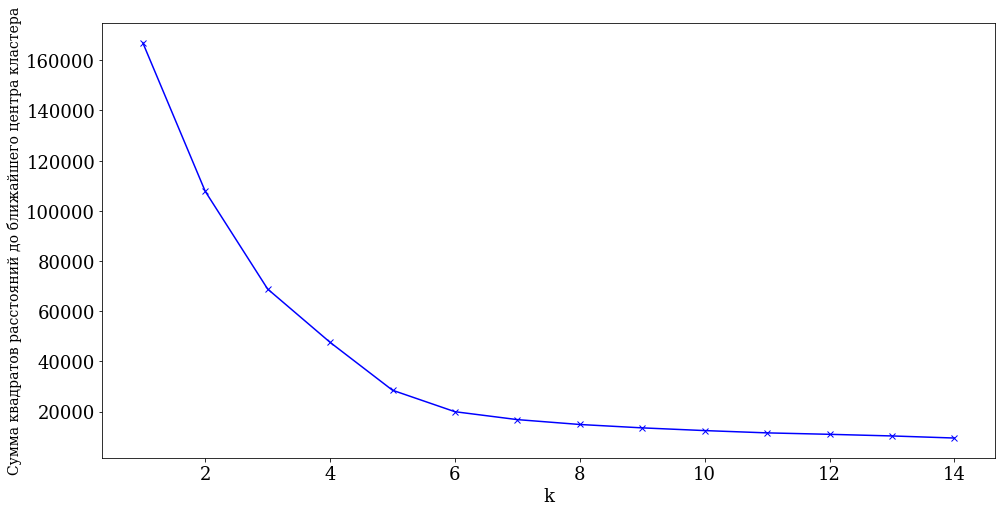

In [227]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1, 15), distortions, 'bx-')
plt.xlabel('k')
ax.tick_params(labelsize = 18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(14)
plt.ylabel('Сумма квадратов расстояний до ближайшего центра кластера')
plt.show()

Из графика видно, что нужно выбрать k=6, то есть разбить выборку на 6 кластеров. Следовательно, из данных можно выделить 6 разных групп

In [228]:
kmeanModel = KMeans(n_clusters=6)
kmeanModel.fit(df1_norm)
df['cluster'] = kmeanModel.labels_

Расчитаем характеристики распределения переменных каждого кластера:

In [229]:
def most_common(series, order = 1):
    '''Возвращает самый популярный (порядка order) объект series'''
    counted = Counter(series).most_common(order)
    if len(counted) >= order: # если нет order-уникальных значений, выдаем None
        return Counter(series).most_common(order)[order - 1][0]
    else:
        return None


def count_7(series):
    '''Считает 7 в series'''
    return (series == 7).sum()


def count_14(series):
    '''Считает 7 в series'''
    return (series == 14).sum()


def count_28(series):
    '''Считает 7 в series'''
    return (series == 28).sum()


def count_56(series):
    '''Считает 7 в series'''
    return (series == 56).sum()


def count_greater_0(series):
    '''Считает количество наблюдений >0 в series'''
    return (series > 0).sum()


df_gr = df.groupby('cluster').agg({'hashed_user_id':['count'],
                                      'mod_user_age':['mean', np.median, np.std], 
                                     'user_friends': ['mean', np.median, np.std], 
                                     'user_communities_count': ['mean', np.median,  np.std],
                                      'user_fans_count': ['mean', np.median, np.std], 
                                      'user_subscriptions_count': ['mean', np.median, np.std],
                                      'days_in_vk_1_week': ['mean', count_7],
                                      'days_in_vk_2_weeks': ['mean', count_14],
                                      'days_in_vk_4_weeks': ['mean', count_28],
                                      'days_in_vk_8_weeks': ['mean', count_56],
                                       'messaging_total': ['mean', np.median,  np.std],
                                      'calls_accepted': count_greater_0,
                                      'timespent_total': ['mean', np.median,  np.std],
                                      'timespent_feed': ['mean', np.median,  np.std], 
                                      'timespent_clips': count_greater_0,
                                      'timespent_story': count_greater_0,
                                      'user_sex_female': sum,
                                      'user_sex_male': sum,
                                      'mod_device_brand_android': sum,
                                      'mod_device_brand_apple': sum,
                                      'mod_device_brand_nan': sum,
                                      'iphone_model': ['mean', np.median]})
# какая доля людей заходила в ВК каждый день за за последние n-дней
df_gr['share_everyday7'] = df_gr['days_in_vk_1_week']['count_7']/df_gr['hashed_user_id']['count']
df_gr['share_everyday14'] = df_gr['days_in_vk_2_weeks']['count_14']/df_gr['hashed_user_id']['count']
df_gr['share_everyday28'] = df_gr['days_in_vk_4_weeks']['count_28']/df_gr['hashed_user_id']['count']
df_gr['share_everyday56'] = df_gr['days_in_vk_8_weeks']['count_56']/df_gr['hashed_user_id']['count']
# доля мужчин
df_gr['share_male'] = df_gr['user_sex_male']['sum']/df_gr['hashed_user_id']['count']
# доля женщин
df_gr['share_female'] = df_gr['user_sex_female']['sum']/df_gr['hashed_user_id']['count']
# доли пользователей отдельных платформ
df_gr['share_android'] = df_gr['mod_device_brand_android']['sum']/df_gr['hashed_user_id']['count']
df_gr['share_apple'] = df_gr['mod_device_brand_apple']['sum']/df_gr['hashed_user_id']['count']
df_gr['share_nan'] = df_gr['mod_device_brand_nan']['sum']/df_gr['hashed_user_id']['count']

In [230]:
df_gr

hashed_user_id mod_user_age         ... share_android share_apple share_nan
                 count         mean median  ...                                    
cluster                                     ...                                    
0                24675    27.914002     25  ...           0.0         1.0       0.0
1                43520    32.440556     29  ...           1.0         0.0       0.0
2                23257    39.898138     37  ...           1.0         0.0       0.0
3                15597    28.016093     24  ...           0.0         1.0       0.0
4                12288    34.706543     31  ...           0.0         0.0       1.0
5                 6556    40.686394     36  ...           0.0         0.0       1.0

[6 rows x 52 columns]

Интересные детали в выделенных группах:


*   Кластеры 1,3,4 - мужские; кластеры 0,2,5 - женские. Это сигнализирует о том, что поведение мужчин и женщин в соцсети значительно различаются.
*   В дополнение к предыдущему пункту: каждый из мужских/женских кластеров относится к конкретной платформе: андроиду, IOS или не использованию мобильных платформ. Значит, пользователи разных платформ ведут себя по-разному.
* Каждый из мужских/женских кластеров символизирует определенный уровень постоянства пользования сетью: 0, 4 - высокий уровень; 2, 1 - средний уровень; 5, 3 - низкий уровень.
* Аналогичные третьему пункту разделения были проведены по суммарному затраченному времени, времени, затраченному на ленту, клипы и истории, количеству подписок. Получается, что совокупная активность пользователей в соцсети может быть символически разделена на три уровня.
* По показателю возраста мужские/женские кластеры были разбиты на 2 "молодых" кластера (с людьми до 30 лет) и на кластер с людьми старше 30. Это вероятно показывает, что потребительские привычки различны среди молодых и что потребительские привычки меняются с возрастом.  



**Заключение**

Таким образом, получается, что пользователей можно разделить на 6 разных групп, каждая из которых будет символизировать различные потребительский привычки